In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
import random
import cv2
import tensorflow as tf 
import keras
import random 
from keras import layers
from keras.models import Model
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
DATADIR = "/home/vinitha/Machine Learning/Text_detection/47Classes100/"

In [3]:
CATEGORIES= os.listdir(DATADIR)

In [4]:
len(CATEGORIES)

47

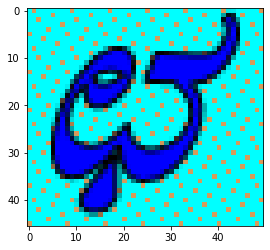

In [5]:
for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #path of the categories 
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.imshow(img_array, cmap="gray")
        plt.show()
        break
    break

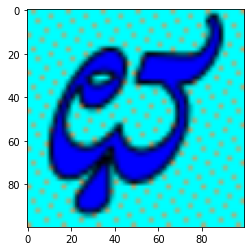

In [6]:
IMG_SIZE = 100
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

## Preparing the training data

In [7]:
training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) #path of the categories 
        
        class_num = CATEGORIES.index(category)
       
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e: 
                pass
 


create_training_data()

In [8]:
random.shuffle(training_data)
print(len(training_data))

4740


In [9]:
X =[]
y=[]
for features, label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)


In [10]:
y = np.array(y)
no_classes = 47
y1 = tf.keras.utils.to_categorical(y, no_classes)

In [11]:
print(X.shape)
print(y.shape)
print(y1.shape)

(4740, 100, 100, 3)
(4740,)
(4740, 47)


In [12]:
X = X/255.0

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y1,test_size=0.1)
print(X_train.shape)
print(X_test.shape)

(4266, 100, 100, 3)
(474, 100, 100, 3)


## Transfer learning from Mobilenet

In [14]:

base_model= tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=layers.GlobalAveragePooling2D()(x)
x=layers.Dropout(0.5)(x)
x=layers.Dense(256,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=layers.Dense(512,activation='relu')(x) #dense layer 2

x=layers.Dense(512,activation='relu')(x) #dense layer 3
preds=layers.Dense(47,activation='softmax')(x) 

9412608/9406464 [==============================] - 3s 0us/step


In [15]:
model=Model(inputs=base_model.input,outputs=preds)
for layers in model.layers[:-6]:
    layers.trainable=False
model.summary()

_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, None, None, 3 1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, None, None, 3 0           block_7_expand_BN[0][0]          
__________________________________________________________________________________________________
block_7_depthwise (DepthwiseCon (None, None, None, 3 3456        block_7_expand_relu[0][0]        
__________________________________________________________________________________________________
block_7_depthwise_BN (BatchNorm (None, None, None, 3 1536        block_7_depthwise[0][0]          
__________________________________________________________________________________________________
block_7_depthwise_relu (ReLU)   (None, None, None, 3 0           block_7_depthwise_BN[0][0

In [16]:
optimizer=tf.keras.optimizers.Adam()
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=optimizer,
              metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=50,
          verbose=1,
          validation_split=0.2)

model.save("/home/vinitha/Machine Learning/Text_detection/mobilenetv2")
print("model saved")

Epoch 1/50
107/107 [==============================] - 27s 250ms/step - loss: 3.6084 - accuracy: 0.0958 - val_loss: 3.0707 - val_accuracy: 0.1956
Epoch 2/50
107/107 [==============================] - 25s 236ms/step - loss: 2.8592 - accuracy: 0.2189 - val_loss: 2.5552 - val_accuracy: 0.2681
Epoch 3/50
107/107 [==============================] - 26s 238ms/step - loss: 2.4658 - accuracy: 0.2860 - val_loss: 2.1621 - val_accuracy: 0.3689
Epoch 4/50
107/107 [==============================] - 25s 237ms/step - loss: 2.1984 - accuracy: 0.3549 - val_loss: 1.9773 - val_accuracy: 0.4040
Epoch 5/50
107/107 [==============================] - 25s 238ms/step - loss: 1.9839 - accuracy: 0.4165 - val_loss: 1.8411 - val_accuracy: 0.4344
Epoch 6/50
107/107 [==============================] - 25s 237ms/step - loss: 1.8321 - accuracy: 0.4449 - val_loss: 1.7294 - val_accuracy: 0.4754
Epoch 7/50
107/107 [==============================] - 25s 237ms/step - loss: 1.7208 - accuracy: 0.4777 - val_loss: 1.5661 - val_ac

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} and Test accuracy: {score[1]}')

Test loss: 1.534661889076233 and Test accuracy: 0.7151898741722107


In [21]:
k=np.random.choice(X_test.shape[0],10)
for i in k:
    img = tf.expand_dims(X_test[i],axis=0)
    y_pred = model.predict(img)
    actual =  np.argmax(y_pred)
    print(np.argmax(y_pred),(actual))

14 14
18 18
12 12
8 8
19 19
15 15
6 6
7 7
14 14
6 6
